# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# HOMEWORK 2 - Unsupervised Deep Learning - Notebook 1/2

**FRANCESCO FONTANA -  matricola 2026924**

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from scipy.stats import loguniform
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)
print(len(train_dataset))
print(len(test_dataset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

60000
10000


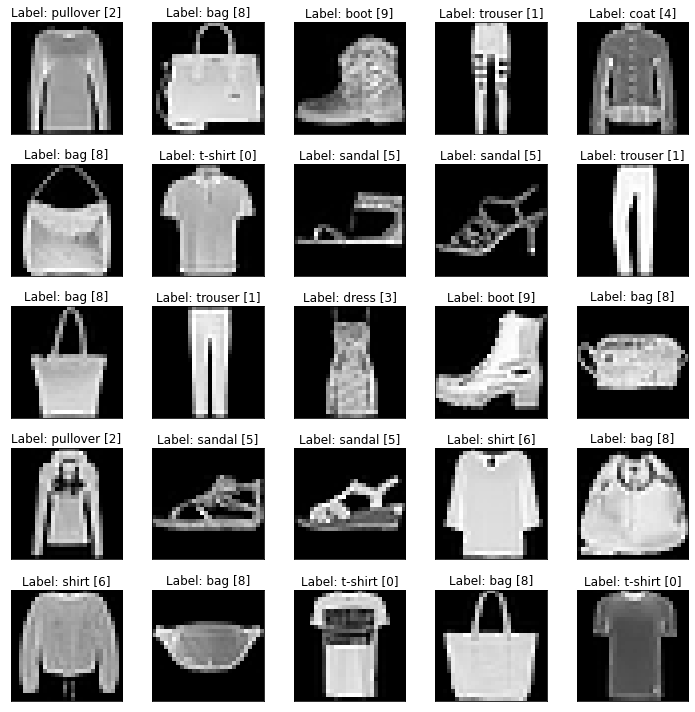

In [ ]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
#Creating directory for storing images and graphs
if os.path.isdir("autoencoders_images")== False:
  os.mkdir("autoencoders_images")

In [ ]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])



# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers = 2, pin_memory = True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers = 2, pin_memory = True)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(p=dropout)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=288, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim
                     )
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=288),
            nn.ReLU(True),
            nn.Dropout(p=dropout)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(2026924)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    #loss_train = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #loss_train.append(loss.data)
    return loss.data#sum(loss_train)/len(loss_train)
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def training_loop(params, train_dataset, test_dataset, save = False, plot_progress= False, print_epoch = False, nfolds=3, cross_validation=False):
    
    ### Set the random seed for reproducible results
    torch.manual_seed(2026924)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Initialize the two networks
    encoded_space_dim = params["en_sp_dim"]
    encoder = Encoder(encoded_space_dim=encoded_space_dim)
    decoder = Decoder(encoded_space_dim=encoded_space_dim)


    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]


  # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    #print(f'Selected device: {device}')


    #Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)  




# -----  CROSS-VALIDATION  -----
    if cross_validation:

    # Define the K-fold Cross Validator
      num_folds = nfolds
      kfold = KFold(n_splits=num_folds, shuffle=True)

      num_epochs  = params["num_epochs"]
      
      train_log_folds = np.zeros((num_folds, num_epochs))
      val_log_folds   = np.zeros((num_folds, num_epochs))

      for f, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
          #print('####################################################################')
          print(f'\n# FOLD {f+1}\n')
          #print('####################################################################\n')

          train_subsampler = SubsetRandomSampler(train_idx)
          val_subsampler   = SubsetRandomSampler(val_idx)
          
          ### Define train dataloader
          train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"], sampler=train_subsampler)
          val_dataloader   = DataLoader(train_dataset, batch_size=params["batch_size"], sampler=val_subsampler)
          
          # Define the loss function
          loss_fn = nn.MSELoss()

          # Define the optimizer
          if   params["opt"] == "Adam":    optim = torch.optim.Adam(params_to_optimize,    lr = params["lr"], weight_decay= params["l2"])
          elif params["opt"] == "RMSprop": optim = torch.optim.RMSprop(params_to_optimize, lr = params["lr"], weight_decay= params["l2"])
          elif params["opt"] == "SGD":     optim = torch.optim.SGD(params_to_optimize,     lr = params["lr"], weight_decay= params["l2"])
          

          ### Training cycle
          num_epochs = params["num_epochs"]
          log_train = np.zeros(num_epochs)
          log_val = np.zeros(num_epochs)
          
          for epoch in tqdm(range(num_epochs)):
          
            ### Training (use the training function)
            train_loss = train_epoch(
                encoder=encoder, 
                decoder=decoder, 
                device=device, 
                dataloader=train_dataloader, 
                loss_fn=loss_fn, 
                optimizer=optim)
            ### Validation  (use the testing function)
            val_loss = test_epoch(
                encoder=encoder, 
                decoder=decoder, 
                device=device, 
                dataloader=val_dataloader, 
                loss_fn=loss_fn)
            
            log_train[epoch] = train_loss
            log_val[epoch] = val_loss

            if print_epoch:
                print('EPOCH %d/%d' % (epoch + 1, num_epochs))
                
                #Print Training loss
                print('\n\t TRAINING - loss: %f\n' % (train_loss))
                #Print Validation loss
                print('\t VALIDATION - loss: %f\n\n' % (val_loss))

          train_log_folds[f] = log_train
          val_log_folds[f]   = log_val

      
      if save:
        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')

      
      return np.mean(train_log_folds, axis = 0), np.mean(val_log_folds, axis = 0)
    
# ----- NOT using Cross-validation -----
    else: 

      ### Define train dataloader
      train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
      test_dataloader  = DataLoader(test_dataset,  batch_size=params["batch_size"], shuffle=False)

      # Define the optimizer
      if   params["opt"] == "Adam":    optim = torch.optim.Adam(params_to_optimize,    lr = params["lr"], weight_decay= params["l2"])
      elif params["opt"] == "RMSprop": optim = torch.optim.RMSprop(params_to_optimize, lr = params["lr"], weight_decay= params["l2"])
      elif params["opt"] == "SGD":     optim = torch.optim.SGD(params_to_optimize,     lr = params["lr"], weight_decay= params["l2"])


      ### Training cycle
      num_epochs = params["num_epochs"]
      log_train = np.zeros(num_epochs)
      log_val = np.zeros(num_epochs)
      
      for epoch in range(num_epochs):
        
          ### Training (use the training function)
          train_loss = train_epoch(
              encoder=encoder, 
              decoder=decoder, 
              device=device, 
              dataloader=train_dataloader, 
              loss_fn=loss_fn, 
              optimizer=optim)
          ### Validation  (use the testing function)
          val_loss = test_epoch(
              encoder=encoder, 
              decoder=decoder, 
              device=device, 
              dataloader=test_dataloader, 
              loss_fn=loss_fn)
          
          log_train[epoch] = train_loss
          log_val[epoch] = val_loss

          if print_epoch:
              print('EPOCH %d/%d' % (epoch + 1, num_epochs))
              #Print Training loss
              print('\n\t TRAINING - loss: %f\n' % (train_loss))
              #Print Validation loss
              print('\t VALIDATION - loss: %f\n\n' % (val_loss))

          if plot_progress:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)
            # Save figures
            os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
            fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
            plt.show()
            plt.close()

      if save:
        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')

      return log_train, log_val


In [ ]:
def random_hyperparameters():

    regularization_type = np.random.choice(['none', 'l2'])
    regularization_strength = 0.
    
    if regularization_type == 'l2': regularization_strength = loguniform.rvs(1e-5, 1e-1)

    hyperparameters = {
        'en_sp_dim': np.random.randint(2, 20),
        'num_epochs': 10,
        'batch_size': np.random.choice([128, 256, 512]).tolist(),
        'lr': loguniform.rvs(1e-4, 1e-1),
        'regularization_type' : regularization_type,
        'regularization_strength' : regularization_strength,
        'l2': regularization_strength if regularization_type == 'l2' else 0.,
        'opt' : np.random.choice(['Adam', 'RMSprop', 'SGD'])
    }
    return hyperparameters

In [ ]:
niter = 30
ae_df = pd.DataFrame(columns = ["en_sp_dim", "batch_size", "lr", "regularization_type"
                            , "regularization_strength", "l2", "opt", "mean_train_loss", "mean_val_loss"], index = range(1,niter+1))

for it in range(1, niter+1):
    r_hy = random_hyperparameters()
    ae_df.loc[it] = r_hy
    loss, val = training_loop(r_hy, train_dataset, test_dataset, cross_validation=False)
    ae_df.loc[it, "mean_train_loss"] = np.mean(loss, dtype = np.float32)
    ae_df.loc[it, "mean_val_loss"] = np.mean(val, dtype = np.float32)
    print("\nTrial", it, "done!")
    
ae_df


Trial 1 done!

Trial 2 done!

Trial 3 done!

Trial 4 done!

Trial 5 done!

Trial 6 done!

Trial 7 done!

Trial 8 done!

Trial 9 done!

Trial 10 done!

Trial 11 done!

Trial 12 done!

Trial 13 done!

Trial 14 done!

Trial 15 done!

Trial 16 done!

Trial 17 done!

Trial 18 done!

Trial 19 done!

Trial 20 done!

Trial 21 done!

Trial 22 done!

Trial 23 done!

Trial 24 done!

Trial 25 done!

Trial 26 done!

Trial 27 done!

Trial 28 done!

Trial 29 done!

Trial 30 done!


,en_sp_dim,batch_size,lr,regularization_type,regularization_strength,l2,opt,mean_train_loss,mean_val_loss
1,19,256,0.009516,none,0.0,0.0,Adam,0.016851,0.01738
2,13,128,0.005384,l2,0.046571,0.046571,SGD,0.131424,0.132115
3,20,256,0.003064,l2,0.002398,0.002398,RMSprop,0.090757,0.092885
4,18,512,0.003042,none,0.0,0.0,SGD,0.160248,0.158641
5,9,256,0.01071,none,0.0,0.0,SGD,0.131423,0.129495
6,9,512,0.045747,l2,0.00027,0.00027,RMSprop,0.092668,0.091889
7,3,512,0.001338,l2,0.067264,0.067264,RMSprop,0.135435,0.135963
8,17,256,0.000119,none,0.0,0.0,RMSprop,0.046336,0.04497
9,9,128,0.046392,l2,0.000106,0.000106,RMSprop,0.092097,0.090432
10,20,512,0.005208,l2,0.001487,0.001487,SGD,0.145504,0.146069


In [ ]:
ae_df = ae_df.astype({"mean_val_loss":float})

# ------ Saving dataframe random grid search ------
ae_df.to_pickle("./random_grid_search_AE.pkl")

# ------ Loading dataframe random grid search ------
ae_df=pd.read_pickle("./random_grid_search_AE.pkl")

best_res = ae_df.nsmallest(10, 'mean_val_loss')
best_res

,en_sp_dim,batch_size,lr,regularization_type,regularization_strength,l2,opt,mean_train_loss,mean_val_loss
1,19,256,0.009516,none,0.0,0.0,Adam,0.016851,0.017380
18,20,256,0.008669,none,0.0,0.0,Adam,0.017302,0.017434
30,10,128,0.002126,l2,0.000038,0.000038,Adam,0.01931,0.019497
23,6,128,0.023384,none,0.0,0.0,Adam,0.020547,0.019980
17,17,256,0.001194,none,0.0,0.0,Adam,0.020483,0.020042
13,9,128,0.005301,none,0.0,0.0,RMSprop,0.021983,0.022235
26,4,128,0.001163,none,0.0,0.0,Adam,0.022738,0.023433
28,16,256,0.001798,l2,0.000016,0.000016,RMSprop,0.027915,0.028353
25,11,256,0.000313,none,0.0,0.0,Adam,0.029817,0.030020
22,8,128,0.000317,l2,0.000146,0.000146,Adam,0.029641,0.030446


# Train with best hyp.

In [ ]:
hyperparameters = {
        'en_sp_dim':19,
        'num_epochs': 100,
        'batch_size': 256,
        'lr': 0.0095,
        'l2': 0,
        'opt' : 'Adam'
    }

In [ ]:
train, val = training_loop(hyperparameters, train_dataset, test_dataset, save = True, plot_progress=False, print_epoch=False, cross_validation=True )


# FOLD 1



100%|██████████| 100/100 [08:48<00:00,  5.29s/it]



# FOLD 2



100%|██████████| 100/100 [08:44<00:00,  5.25s/it]



# FOLD 3



100%|██████████| 100/100 [08:45<00:00,  5.25s/it]


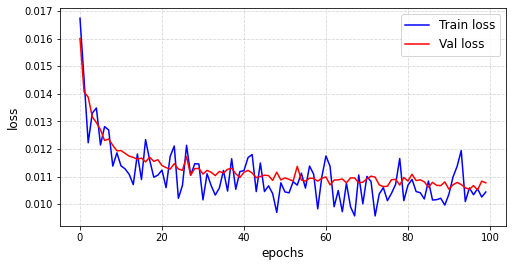

In [ ]:
size = 12
fig = plt.figure(figsize=(8,4))
plt.plot(train, color = "blue", label = "Train loss")
plt.plot(val, color = "red", label = "Val loss")
plt.xlabel("epochs", fontsize = size)
plt.ylabel("loss", fontsize = size)
plt.legend(fontsize = size)
plt.grid(linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("autoencoders_images/std_autoenc_train.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## Load encoder and decoder

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
encoded_space_dim = 19
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
encoder.to(device)
decoder.to(device)

# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

## Reconstruct some samples

Selected device: cuda


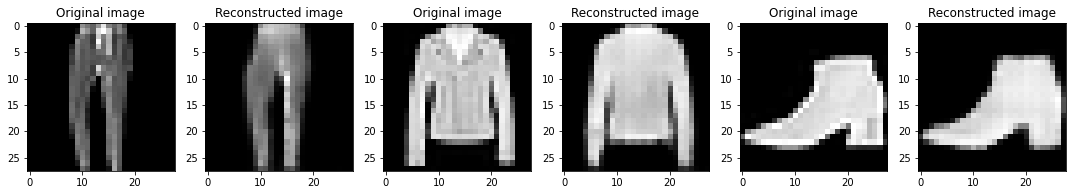

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'Selected device: {device}')

fig, axs = plt.subplots(1, 6, figsize=(15,5))

for i, idx in enumerate([80,357,810]):
 
  img = test_dataset[idx][0].unsqueeze(0).to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img  = decoder(encoder(img))
  
  # Plot the reconstructed image
  axs[2*i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[2*i].set_title('Original image', size = size)
  axs[2*i + 1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[2*i + 1].set_title('Reconstructed image', size = size)
  plt.tight_layout()

fig.savefig("autoencoders_images/example_reconstruction.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

## Generate new samples

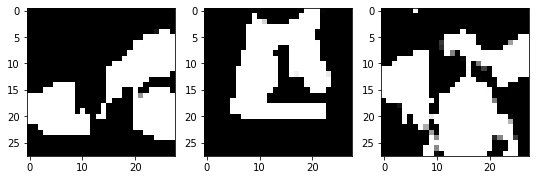

In [ ]:
# Generate a custom sample
custom_encoded_sample1 = np.random.randn(19)*100
encoded_value1 = torch.tensor(custom_encoded_sample1).float().unsqueeze(0).to(device)
custom_encoded_sample2 = np.random.randn(19)*100
encoded_value2 = torch.tensor(custom_encoded_sample2).float().unsqueeze(0).to(device)
custom_encoded_sample3 = np.random.randn(19)*100
encoded_value3 = torch.tensor(custom_encoded_sample3).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img1 = decoder(encoded_value1)
    generated_img2 = decoder(encoded_value2)
    generated_img3 = decoder(encoded_value3)

# Plot the reconstructed image
fig, axs = plt.subplots(1, 3, figsize=(9,6))
axs[0].imshow(generated_img1.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].imshow(generated_img2.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].imshow(generated_img3.cpu().squeeze().numpy(), cmap='gist_gray')

# Save figures
fig.savefig('autoencoders_images/ae_newgen.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# ---- Test Set

loss_fn = torch.nn.MSELoss()
test_loss = test_epoch(encoder=encoder,
                       decoder=decoder,
                       device=device,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn)
print('\nTest loss:', test_loss.numpy())


Test loss: 0.010805504


In [ ]:
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.8842


## Transfer learning for classification

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoded_space_dim = 19
encoder = Encoder(encoded_space_dim=encoded_space_dim)
encoder.to(device)

# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))


Selected device: cuda


<All keys matched successfully>

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoded_space_dim, pretrained_encoder):
        super().__init__()
        # Encoder
        self.encoder = pretrained_encoder
        # Fine tune layers for classification
        self.sup_learn = nn.Sequential(nn.Linear(encoded_space_dim, 128),
                                             nn.ReLU(True),
                                             nn.Linear(128, 10),
                                             nn.LogSoftmax(dim=-1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.sup_learn(x)
        return x

In [ ]:
net = Classifier(encoded_space_dim=19, pretrained_encoder=encoder)
net.to(device)

Classifier(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
      (6): Dropout(p=0, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=19, bias=True)
    )
  )
  (sup_learn): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

In [ ]:
loss_fn = nn.NLLLoss()

# Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=0.0005, weight_decay=0)

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)
print("Training dataset:", len(train_dataset),"images")
print("Test dataset:", len(test_dataset),"images")
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

Training dataset: 60000 images
Test dataset: 10000 images


In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print("Training set size:", train_size)
print("Validation set size:", val_size)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers = 2, pin_memory = True)
val_dataloader  = DataLoader(val_dataset,  batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

num_epochs = 25
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('\n################\n')
    print(f'EPOCH {epoch_num+1}\n')
    
    train_loss = []
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
        # Move data to device
        x = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        # Forward pass
        out = net.forward(x)
        # Compute loss
        loss = loss_fn(out, label)
        # Backpropagation
        net.zero_grad()
        loss.backward()
        # Update the weights
        optim.step()
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        # Save average train loss 
    train_loss = np.mean(train_loss)
    print(f"\tAverage train loss: {train_loss}")
    train_loss_log.append(train_loss)
    # .................... VALIDATION .....................
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x = sample_batched[0].to(device)
            label = sample_batched[1].to(device)
            # Forward pass
            out = net.forward(x)
            # Compute loss
            loss = loss_fn(out, label)
            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"\tAverage validation loss: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)

Training set size: 48000
Validation set size: 12000

################

EPOCH 1

	Average train loss: 0.6557042002677917
	Average validation loss: 0.44664666056632996

################

EPOCH 2

	Average train loss: 0.4216962456703186
	Average validation loss: 0.3999050259590149

################

EPOCH 3

	Average train loss: 0.3853110373020172
	Average validation loss: 0.37455371022224426

################

EPOCH 4

	Average train loss: 0.36111074686050415
	Average validation loss: 0.3584810197353363

################

EPOCH 5

	Average train loss: 0.3441576361656189
	Average validation loss: 0.3484519124031067

################

EPOCH 6

	Average train loss: 0.3324401378631592
	Average validation loss: 0.3412852883338928

################

EPOCH 7

	Average train loss: 0.32169005274772644
	Average validation loss: 0.3392731547355652

################

EPOCH 8

	Average train loss: 0.31428876519203186
	Average validation loss: 0.32829737663269043

################

EPOCH 9

	Average t

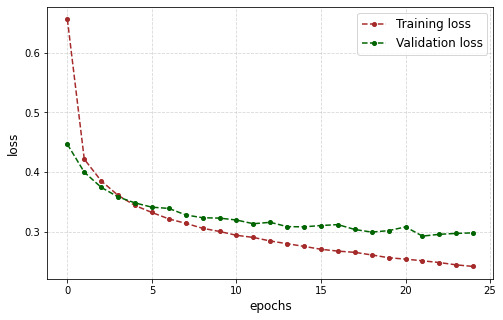

In [ ]:
size = 12
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss_log, color = "brown", ls="--",marker='.',markersize=8, label = "Training loss")
plt.plot(val_loss_log, color = "darkgreen", ls="--",marker='.',markersize=8, label = "Validation loss")

plt.xlabel("epochs", fontsize = size)
plt.ylabel("loss", fontsize = size)
plt.legend(fontsize = size)
#plt.xticks(np.arange(0, num_epochs+1, step=5))
plt.grid(linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("autoencoders_images/transfer_learning_training.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
test_loss = []
outputs = [] 
labels = []

net.eval()
with torch.no_grad(): 
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        # Compute net output
        out = net(x_batch)
        outputs.append(out)
        labels.append(label)
        # Append the network output and the original image to the lists
        loss = loss_fn(out, label)
        test_loss.append(loss.detach().cpu().numpy())
# concatenate the outputs and labels in a single tensor
outputs = torch.cat(outputs)
labels = torch.cat(labels)
test_loss = np.mean(test_loss)
test_loss

0.32847437

In [ ]:
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.8842


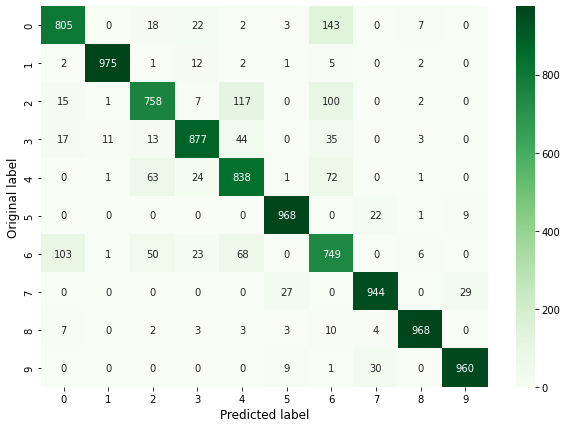

In [ ]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Evaluate confusion matrix
cm = confusion_matrix(labels, predicted_labels)
# Show the confusion matrix
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, cmap='Greens', fmt='d', annot=True)
plt.ylabel('Original label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('autoencoders_images/FN_cmap.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Latent space visualization with PCA and t-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
#!pip install -U kaleido --quiet #silent installation

     |████████████████████████████████| 79.9 MB 64.7 MB/s 


In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:14<00:00, 699.65it/s]


In [ ]:
# Convert to a dataframe (for convenience)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,Enc. Variable 16,Enc. Variable 17,Enc. Variable 18,label
0,-0.745528,-0.147669,1.656794,2.182060,0.689291,1.293459,-0.791348,-1.375463,3.032808,-0.527462,0.180639,-0.167641,4.263062,-1.543980,-0.064046,2.686833,1.495583,-0.025538,-0.297638,9
1,-2.458153,-0.861219,3.441742,-0.919266,0.015818,0.644483,-1.191074,1.584143,12.277387,1.124336,-7.471755,-2.224994,-2.170983,-0.173859,-0.844032,-0.103729,-1.718492,1.263691,1.832256,2
2,-0.450301,-2.157421,-1.169049,0.742984,0.842496,1.047518,0.348605,-0.405218,3.881950,-1.672847,5.398787,0.876291,-7.145734,-0.055090,2.118806,-2.629051,-0.269016,-0.308938,0.745717,1
3,0.321186,-2.446496,-0.413954,-0.486711,-1.147145,0.788124,0.704353,-2.188249,1.512787,-0.658787,2.855465,-0.237033,-5.540190,-1.210224,-0.002961,-0.640263,-0.787125,1.057728,0.035504,1
4,2.735538,-0.580098,0.529673,0.234546,-0.575993,-0.111712,-0.134403,3.181843,8.240744,-1.195460,-2.954869,-1.151525,-2.493700,-2.100543,-1.651137,0.104415,1.195549,-0.828817,1.397013,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.086774,-0.993712,0.368390,-0.366884,3.210188,1.749786,0.289029,-0.660280,6.456248,-3.306587,-2.020288,0.787656,4.776331,0.034039,-0.362386,3.468717,2.429293,-0.557066,-0.598981,9
9996,-0.336034,-0.496490,-0.196039,-0.389950,-0.903901,0.767071,-0.248363,-2.208302,0.704350,-0.093012,1.424232,-0.188744,-3.920348,-0.071401,-1.009712,-0.786775,-0.189186,1.636530,0.866349,1
9997,-1.659250,-0.196683,2.019640,-2.407115,-1.883133,-3.694603,-1.249929,-0.859854,6.157547,-1.167815,3.448829,0.300275,-0.689565,0.227028,0.014220,0.400065,2.156201,0.306505,1.416938,8
9998,1.346939,-0.735440,-0.440724,-1.641817,0.138262,2.255832,1.125315,-3.928791,1.147979,0.589396,4.079789,0.808858,-6.057374,0.476593,-0.088907,-0.516542,1.728693,1.446334,-0.516879,1


In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

pca_transf_samples = pd.DataFrame(pca.transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(pca_transf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

In [ ]:
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

tsne_tranf_samples = pd.DataFrame(tsne.fit_transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(tsne_tranf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



# Variational Autoencoders

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_data = torchvision.datasets.FashionMNIST('dataset', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('dataset', train=False,
                           transform=transforms.ToTensor())

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=256, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=256, shuffle=True, **kwargs)

In [ ]:
Z_DIM = 19
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, Z_DIM)  # fc21 for mean of Z
        self.fc22 = nn.Linear(500, Z_DIM)  # fc22 for log variance of Z
        self.fc3 = nn.Linear(Z_DIM, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
lr = 1e-3
net = VAE().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
net

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc21): Linear(in_features=500, out_features=19, bias=True)
  (fc22): Linear(in_features=500, out_features=19, bias=True)
  (fc3): Linear(in_features=19, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    return BCE + KLD

In [ ]:
def train(epoch):
    net.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        # data: [batch size, 1, 28, 28]
        # label: [batch size] -> we don't use
        optimizer.zero_grad()
        data = data.to(device)
        recon_data, mu, logvar = net(data)
        loss = loss_function(recon_data, data, mu, logvar)
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()

    print('====> Epoch: {} <==== \t Average train loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))

In [ ]:
def test(epoch):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            recon_data, mu, logvar = net(data)
            cur_loss = loss_function(recon_data, data, mu, logvar).item()
            test_loss += cur_loss
            

    test_loss /= len(test_loader.dataset)
    print('\t\t\t Test set loss: {:.4f}'.format(test_loss))

In [ ]:
def save_generated_img(image, name, epoch, nrow=8):
    if not os.path.exists('vae_results'):
        os.makedirs('vae_results')

    if epoch % 5 == 0:
        save_path = 'vae_results/'+ name +'_'+ str(epoch)+'.png'
        save_image(image, save_path, nrow=nrow )

In [ ]:
def sample_from_model(epoch):
    with torch.no_grad():
        # p(z) = N(0,I), this distribution is used when calculating KLD. So we can sample z from N(0,I)
        sample = torch.randn(16, Z_DIM).to(device)
        sample = net.decode(sample).cpu().view(16, 1, 28, 28)
        print("\n")
        save_generated_img(sample, 'sample', epoch, nrow=4)

In [ ]:
for epoch in range(1, 101):
        train(epoch)
        test(epoch)
        sample_from_model(epoch)

====> Epoch: 1 <==== 	 Average train loss: 279.8050
			 Test set loss: 250.6809


====> Epoch: 2 <==== 	 Average train loss: 243.9993
			 Test set loss: 242.4736


====> Epoch: 3 <==== 	 Average train loss: 238.5610
			 Test set loss: 238.8585


====> Epoch: 4 <==== 	 Average train loss: 235.5228
			 Test set loss: 236.2073


====> Epoch: 5 <==== 	 Average train loss: 233.6068
			 Test set loss: 234.8113


====> Epoch: 6 <==== 	 Average train loss: 232.2151
			 Test set loss: 233.6026


====> Epoch: 7 <==== 	 Average train loss: 231.2330
			 Test set loss: 232.7173


====> Epoch: 8 <==== 	 Average train loss: 230.4611
			 Test set loss: 232.3099


====> Epoch: 9 <==== 	 Average train loss: 229.8476
			 Test set loss: 231.5903


====> Epoch: 10 <==== 	 Average train loss: 229.3680
			 Test set loss: 231.1288


====> Epoch: 11 <==== 	 Average train loss: 228.9231
			 Test set loss: 230.9293


====> Epoch: 12 <==== 	 Average train loss: 228.5521
			 Test set loss: 230.3424


====> Epoch: 

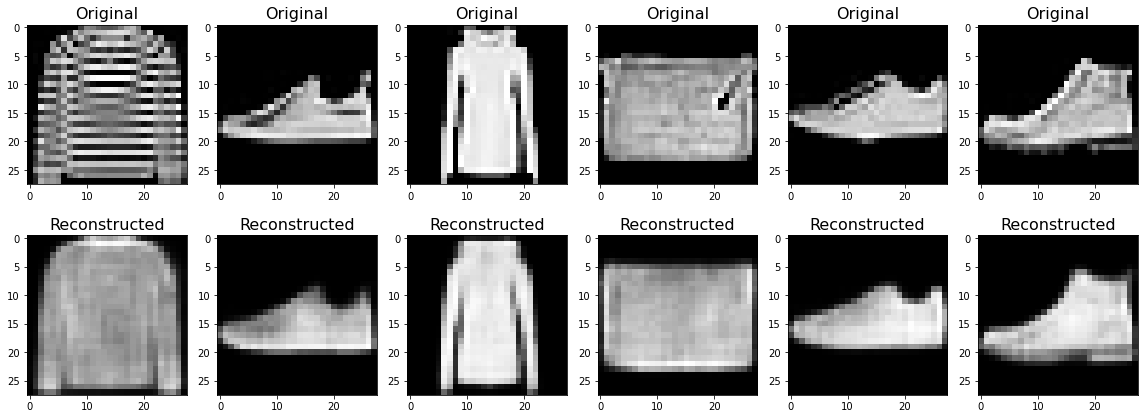

In [ ]:
size = 16
fig, axs = plt.subplots(2, 6, figsize=(16,6))

for i, idx in enumerate(random.sample(range(len(test_dataset)) , 6)):
 
  img = test_dataset[idx][0].unsqueeze(0).to(device)
  net.eval()
  with torch.no_grad():
      rec_img,_,__ = net(img)
  
  # Plot the reconstructed image
  axs[0,i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0,i].set_title('Original', size = size)
  axs[1,i].imshow(rec_img.view(28, 28).cpu().numpy(), cmap='gist_gray')
  axs[1,i].set_title('Reconstructed', size = size)
  plt.tight_layout()

  plt.savefig('autoencoders_images/VAE_reconstruction.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
